In [1]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [2]:
st = default_timer()

# First time data load.
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
    
# Organise a bit and store into feather-format
movies.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movieId', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
Number of movies Null values:  22
Number of ratings Null values:  0
Elapsed time(sec):  61.37


H:\python\lib\site-packages\ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys


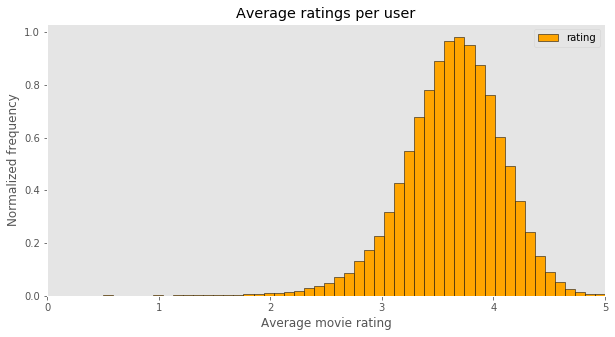

Elapsed time(sec):  4.27


In [11]:
st = default_timer()

dftmp = ratings[['userId','rating']].groupby('userId').mean()
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=0, normed=True,color='orange',edgecolor='black', figsize=(10,5))
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, normed=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^base$|^cumulative$|^values$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))


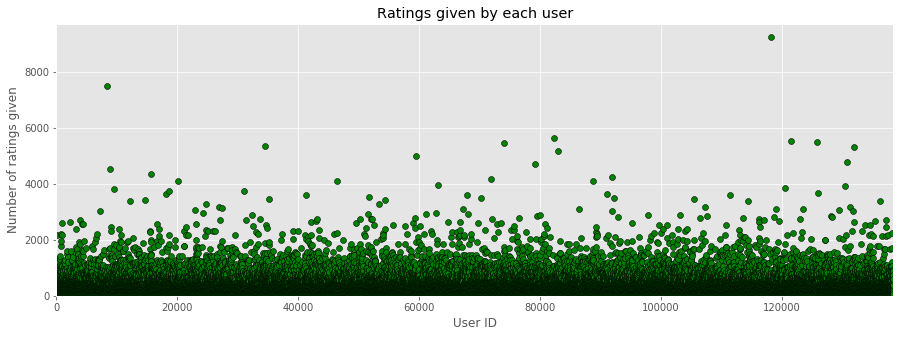

In [16]:
st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings,color='Green', edgecolor='black')
plt.xlim(0,len(dftmp.index))
plt.ylim(0,)
plt.title('Ratings given by each user')
plt.xlabel('User ID')
plt.ylabel('Number of ratings given')
plt.show()

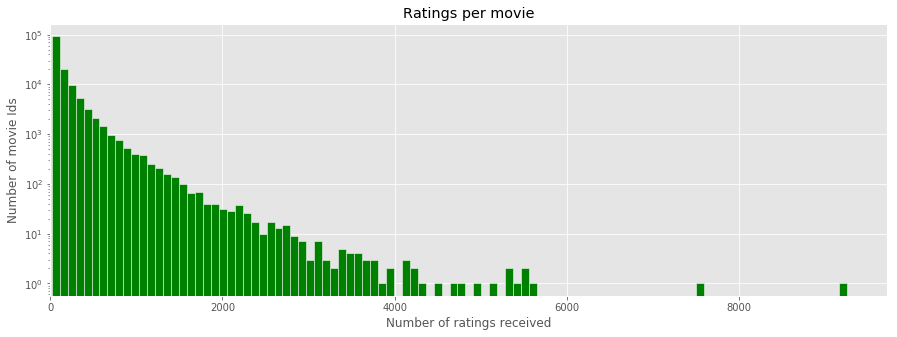

In [20]:
# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100,color='green' ,edgecolor='white', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movie Ids')
plt.xlim(0,)
plt.show()